# Training a Computer Vision Model to Identify Playing Cards
Our goal here it to train a model that can label an image based on a single card somewhere in the image. The card is from a standard 52 card deck with the normal four suits.

#### Start by importing the necessary packages.

In [1]:
import torch
import torch.nn as nn
from random import choice, randint
from util import add_background

from torchvision import models, utils
from torchvision.datasets import ImageFolder, FakeData
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype

# Configure the Dataset

In order to train the model to recognize any card from a deck, we need a dataset containing images of the cards. Normally to train a image classifier we would need hundreds or thousands of images, but we can get away with only needing a single image of each card. Here is an example of an image of a card. Notice how there is no background just the card, this is important for the next step.

club-5


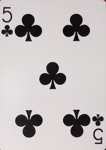

In [2]:
cards = ImageFolder('../data/bicycle_cards')
img, label = choice(cards)
print(cards.classes[label])
img.resize((img.width // 20, img.height // 20))

# Augmenting the Dataset
This dataset with one image of each card however, is not enough. If we just train on this dataset, the model will only work with images of cards without backgrounds. We want the model to be able to recognize any image that has a card in it. To do this we need to train the model with images were the card is just a portion of the image (maybe even a portion of the card is out of frame). Rather than taking thousands of different pictures, we can simplify our task by agumenting our data with artificial backgrounds. We do this by first creating a second dataset of fake images. Everytime we get an image from our card dataset, we randomly sample a fake image from this second dataset. Then we can paste the image of the card on the fake image. It is important that everytime we cycle through the images of the cards, we pair them with different fake images, otherwise the model might learn to label images based on their backgrounds instead of by the card.

In [3]:
channel = 3
width = 224
height = 224
fake_images = FakeData(1000, (channel, width, height))

class RandomBackground(torch.nn.Module):
    def forward(self, img):
        # Pick a random background image from the fake dataset
        background = choice(fake_images)[0]

        # Pick a random location, but makesure at least he top left quarter of the image will be visible
        x, y = randint(0, background.width-img.width//2), randint(0, background.height-img.height//2)

        # Put the image of the card on top of the background with the top left corner at the randomly selected loaction
        background.paste(img, (x, y))
        return background


add_background = Compose([
    # resize the images to be half the height of the background image
    Resize((height * 3 // 4, width // 2)),

    # And a random background to the image
    RandomBackground(),

    # Convert the image to a tensor scaled between 0 and 1
    ToImage(),
    ToDtype(torch.float32, scale=True),
])

We could make are model even more robust by adding noise, rotating, and changing the size of the image of the card before pairing it with a random background. This would help the model recoginize cards in images with varied lighting, different orientations, and different distances from the camera. But here we will stick to the simplest case to reduce the training time.

# Setup the Dataset and Dataloader

spade-6


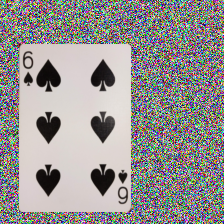

In [5]:
# You can change the batch size depending on available resources
cards_with_background = ImageFolder('../data/bicycle_cards', transform=add_background)

# Display an example of a card with a background
from torchvision.transforms.functional import to_pil_image
img, label = choice(cards_with_background)
img = to_pil_image(img)
print(cards.classes[label])
img.resize((img.width, img.height))

Change the batch size according to available resources.

In [6]:
train_loader = torch.utils.data.DataLoader(cards_with_background, batch_size=8, shuffle=True)

# Configure the Model
We will use resnet, a popular model commonly used for image classification tasks like ours. We will also use the pytorch lightning package to help train our model. 

In [7]:
import lightning as L
import torch.optim as optim

class lightningClassifier(L.LightningModule):
    def __init__(self, num_classes=52) -> None:
        super().__init__()
        resnet_model = models.resnet18(weights='IMAGENET1K_V1')
        num_ftrs = resnet_model.fc.in_features
        resnet_model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = resnet_model

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.model(x)
        loss = nn.functional.cross_entropy(z, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

num_classes = len(cards.classes)
classifier = lightningClassifier(num_classes)

# Train the Model
Training vision classification models can be computationally expensive. To fully train this model set `max_epochs=1000`, but first run the cell to confirm everything works. Alternatively, you can use a pretrained netowrk (see "LoadingModel.ipynb").

In [ ]:
trainer = L.Trainer(max_epochs=1000)
trainer.fit(model=classifier, train_dataloaders=train_loader)

# Visualize Results

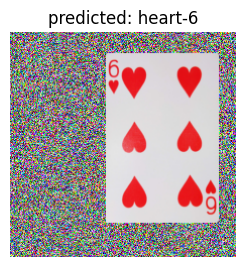

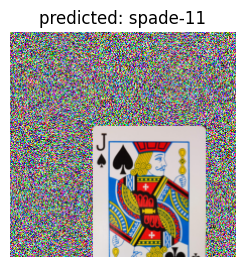

In [11]:
import matplotlib.pyplot as plt
import numpy as np

classifier.eval()
model = classifier.model
device = classifier.device

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {cards_with_background.classes[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, 2)